<a href="https://colab.research.google.com/github/ANotFox/FDS-Implementation/blob/main/fds_implementation_new%5E3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirement of NLTK

In [2]:
!pip install nltk

In [3]:
import nltk
nltk.download('all')
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from collections import defaultdict

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

# SVD2 and main

## SVD2 class and preprocessing

In [26]:
class SVD2Tagger:
    def __init__(self, w1=1000, r1=100, k1=500, r2=300, k2=45):
        """
        Initialize SVD2 tagger with parameters
        w1: number of most frequent words for context
        r1: rank for first SVD
        k1: number of clusters for first clustering
        r2: rank for second SVD
        k2: final number of POS tags
        """
        self.w1 = w1
        self.r1 = r1
        self.k1 = k1
        self.r2 = r2
        self.k2 = k2

    def build_context_matrices(self, tokens, vocab_size, word_to_id):
        """Build left and right context matrices"""
        # Get most frequent word indices
        word_counts = np.bincount(tokens)
        top_words = np.argsort(word_counts)[-self.w1:]

        # Initialize context matrices
        L = np.zeros((vocab_size, self.w1))
        R = np.zeros((vocab_size, self.w1))

        # Fill context matrices
        for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # Right context
            next_word = tokens[i+1]
            if next_word in top_words:
                R[curr_word, np.where(top_words == next_word)[0][0]] += 1

            # Left context
            if i > 0:
                prev_word = tokens[i-1]
                if prev_word in top_words:
                    L[curr_word, np.where(top_words == prev_word)[0][0]] += 1

        return L, R

    def svd_transform(self, matrix, rank):
        """Perform reduced rank SVD and return transformed matrix"""
        U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
        # Keep only top rank singular values
        S = np.diag(S[:rank])
        U = U[:, :rank]
        return normalize(U @ S)

    # def cluster_descriptors(self, descriptors, n_clusters, word_counts):
    #     """Perform weighted k-means clustering"""
    #     # Initialize centroids with most frequent words
    #     top_indices = np.argsort(word_counts)[-n_clusters:]
    #     init_centroids = descriptors[top_indices]

    #     kmeans = KMeans(n_clusters=n_clusters, init=init_centroids, n_init=1)

    #     # init centroids removed so that multiple n_init are possible
    #     # kmeans = KMeans(n_clusters=n_clusters, n_init=1)
    #     return kmeans.fit_predict(descriptors)

    def cluster_descriptors(self, descriptors, n_clusters, word_counts):
      """
      Perform weighted k-means clustering with specialized initialization and updates

      Args:
          descriptors: array of word descriptors (normalized to unit length)
          n_clusters: number of clusters k
          word_counts: frequency of each word in corpus
      """

      # Custom initialization with most frequent words
      top_indices = np.argsort(word_counts)[-n_clusters:]
      init_centroids = descriptors[top_indices]

      # Normalize initial centroids to unit length (ensure they're on 2-sphere)
      init_centroids = init_centroids / np.linalg.norm(init_centroids, axis=1)[:, np.newaxis]

      # Initialize variables
      n_points = descriptors.shape[0]
      labels = np.zeros(n_points, dtype=int)
      centroids = init_centroids.copy()

      # Iterative clustering
      max_iters = 100
      # max_iters = 200
      # changing max_iters to 200 does not change the accuracy
      for _ in range(max_iters):
          old_labels = labels.copy()

          # Assign points to nearest centroid using dot product similarity
          similarities = np.dot(descriptors, centroids.T)  # dot product for cosine similarity
          labels = np.argmax(similarities, axis=1)

          # If no points changed clusters, we've converged
          if np.all(old_labels == labels):
              break

          # Update centroids as weighted average
          for i in range(n_clusters):
              mask = (labels == i)
              if np.any(mask):
                  # Weighted average using word frequencies
                  weights = word_counts[mask]
                  weighted_sum = np.sum(descriptors[mask] * weights[:, np.newaxis], axis=0)
                  centroids[i] = weighted_sum / np.sum(weights)

                  # Normalize to unit length (project back onto 2-sphere)
                  centroids[i] = centroids[i] / np.linalg.norm(centroids[i])

      return labels

    def fit(self, tokens, vocab_size, word_to_id):
        """Perform full SVD2 training process"""
        # First pass
        print("Building initial context matrices...")
        L1, R1 = self.build_context_matrices(tokens, vocab_size, word_to_id)

        print("Performing first SVD transformation...")
        L1_transformed = self.svd_transform(L1, self.r1)
        R1_transformed = self.svd_transform(R1, self.r1)

        # Concatenate descriptors
        descriptors1 = np.hstack([L1_transformed, R1_transformed])

        print("Performing first clustering...")
        word_counts = np.bincount(tokens)
        first_clusters = self.cluster_descriptors(descriptors1, self.k1, word_counts)

        # Second pass
        print("Building refined context matrices...")
        L2 = np.zeros((vocab_size, self.k1))
        R2 = np.zeros((vocab_size, self.k1))

        # Fill second pass context matrices using cluster assignments
        for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # Right context
            next_word = tokens[i+1]
            R2[curr_word, first_clusters[next_word]] += 1

            # Left context
            if i > 0:
                prev_word = tokens[i-1]
                L2[curr_word, first_clusters[prev_word]] += 1

        print("Performing second SVD transformation...")
        L2_transformed = self.svd_transform(L2, self.r2)
        R2_transformed = self.svd_transform(R2, self.r2)

        # Final clustering
        print("Performing final clustering...")
        descriptors2 = np.hstack([L2_transformed, R2_transformed])
        self.final_clusters = self.cluster_descriptors(descriptors2, self.k2, word_counts)

        return self.final_clusters

    def get_cluster_examples(self, tokens, word_to_id, n_examples=5):
        """Get example words for each cluster"""
        id_to_word = {v: k for k, v in word_to_id.items()}
        cluster_examples = defaultdict(list)

        for word_id in range(len(self.final_clusters)):
            cluster = self.final_clusters[word_id]
            if word_id in id_to_word:
                word = id_to_word[word_id]
                cluster_examples[cluster].append(word)

        # Print top n examples for each cluster
        for cluster in sorted(cluster_examples.keys()):
            examples = cluster_examples[cluster][:n_examples]
            print(f"Cluster {cluster}: {', '.join(examples)}")

# # Example usage
# tagger = SVD2Tagger(w1=1000, r1=100, k1=500, r2=300, k2=45)
# clusters = tagger.fit(train_data, vocab_size, word_to_id)
# print("\nCluster Examples:")
# tagger.get_cluster_examples(train_data, word_to_id)

In [5]:
from typing import List, Dict, Tuple

def prepare_treebank_data(tagged_sents: List[List[Tuple[str, str]]]) -> Tuple[np.ndarray, Dict, int]:
    """
    Prepare Penn Treebank data for SVD2Tagger

    Args:
        tagged_sents: List of sentences, where each sentence is a list of (word, tag) tuples

    Returns:
        tokens: numpy array of word IDs
        word_to_id: dictionary mapping words to IDs
        vocab_size: size of vocabulary
    """
    # Build vocabulary
    word_to_id = {}
    words = [word.lower() for sent in tagged_sents for word, _ in sent]

    # Add words to vocabulary with frequency > 1
    word_freq = defaultdict(int)
    for word in words:
        word_freq[word] += 1

    # Create word_to_id mapping
    for word in word_freq:
        if word_freq[word] > 1:  # Only include words that appear more than once
            word_to_id[word] = len(word_to_id)

    # Add <UNK> token
    word_to_id['<UNK>'] = len(word_to_id)

    # Convert words to IDs
    tokens = []
    for sent in tagged_sents:
        for word, _ in sent:
            word = word.lower()
            if word in word_to_id:
                tokens.append(word_to_id[word])
            else:
                tokens.append(word_to_id['<UNK>'])

    return np.array(tokens), word_to_id, len(word_to_id)

def calculate_M1_score(true_tags, predicted_clusters):
    """
    Calculate Many-to-One accuracy score
    Each cluster is mapped to its most common true tag
    """
    # Create mapping from cluster to most common tag
    cluster_to_tag = defaultdict(lambda: defaultdict(int))

    # Count tag occurrences for each cluster
    for cluster, tag in zip(predicted_clusters, true_tags):
        cluster_to_tag[cluster][tag] += 1

    # Assign each cluster to its most frequent tag
    cluster_tag_mapping = {}
    for cluster in cluster_to_tag:
        majority_tag = max(cluster_to_tag[cluster].items(), key=lambda x: x[1])[0]
        cluster_tag_mapping[cluster] = majority_tag

    # Calculate accuracy
    correct = 0
    total = len(true_tags)

    for pred, true in zip(predicted_clusters, true_tags):
        if pred in cluster_tag_mapping and cluster_tag_mapping[pred] == true:
            correct += 1

    return correct / total

def calculate_1to1_score(true_tags, predicted_clusters):
    """
    Calculate One-to-One accuracy score using the Hungarian algorithm
    Each cluster can only be mapped to one true tag
    """
    # Get unique tags and clusters
    unique_tags = sorted(set(true_tags))
    unique_clusters = sorted(set(predicted_clusters))

    # Create confusion matrix
    confusion_matrix = np.zeros((len(unique_clusters), len(unique_tags)))

    # Fill confusion matrix
    for cluster, tag in zip(predicted_clusters, true_tags):
        cluster_idx = unique_clusters.index(cluster)
        tag_idx = unique_tags.index(tag)
        confusion_matrix[cluster_idx][tag_idx] += 1

    # Use Hungarian algorithm to find optimal one-to-one mapping
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

    # Create mapping from cluster to tag
    cluster_tag_mapping = {unique_clusters[i]: unique_tags[j]
                          for i, j in zip(row_ind, col_ind)}

    # Calculate accuracy
    correct = 0
    total = len(true_tags)

    for pred, true in zip(predicted_clusters, true_tags):
        if pred in cluster_tag_mapping and cluster_tag_mapping[pred] == true:
            correct += 1

    return correct / total

def evaluate_clusters(tagger, test_sents, true_tags):
    """
    Evaluate cluster quality against true POS tags
    """
    from sklearn.metrics import v_measure_score, adjusted_rand_score

    # Get cluster assignments for test words
    test_clusters = []
    true_pos_tags = []

    # Collect valid clusters and tags
    for sent, true_sent in zip(test_sents, true_tags):
        for word, true_tag in zip(sent, true_sent):
            word = word.lower()
            if word in tagger.word_to_id:
                word_id = tagger.word_to_id[word]
                if word_id < len(tagger.final_clusters):  # Add check for valid word_id
                    test_clusters.append(tagger.final_clusters[word_id])
                    true_pos_tags.append(true_tag)

    if not test_clusters:
        print("Warning: No valid clusters found for evaluation")
        return {
            'v_measure': 0.0,
            'ari': 0.0,
            'many_to_one': 0.0,
            'one_to_one': 0.0
        }

    # Calculate clustering metrics
    v_measure = v_measure_score(true_pos_tags, test_clusters)
    ari = adjusted_rand_score(true_pos_tags, test_clusters)
    m1_score = calculate_M1_score(true_pos_tags, test_clusters)
    one_to_one_score = calculate_1to1_score(true_pos_tags, test_clusters)

    # Get cluster distribution for each POS tag
    tag_cluster_dist = defaultdict(lambda: defaultdict(int))
    for tag, cluster in zip(true_pos_tags, test_clusters):
        tag_cluster_dist[tag][cluster] += 1

    # # Print detailed distribution
    # print("\nCluster Distribution for each POS tag:")
    # for tag in sorted(tag_cluster_dist.keys()):
    #     clusters = tag_cluster_dist[tag]
    #     total = sum(clusters.values())
    #     main_clusters = sorted(clusters.items(), key=lambda x: x[1], reverse=True)[:3]
    #     print(f"\n{tag}:")
    #     for cluster, count in main_clusters:
    #         print(f"  Cluster-{cluster}: {count/total*100:.1f}%")

    return {
        'v_measure': v_measure,
        'ari': ari,
        'many_to_one': m1_score,
        'one_to_one': one_to_one_score
    }

## Main

In [37]:
def main():
    # Load Penn Treebank data
    print("Loading Penn Treebank data...")
    corpus = nltk.corpus.treebank.tagged_sents()

    # Split into train and test
    train_size = int(len(corpus) * 0.8)
    train_data = corpus[:train_size]
    test_data = corpus[train_size:]

    # Prepare data
    print("Preparing data...")
    tokens, word_to_id, vocab_size = prepare_treebank_data(train_data)

    # Initialize and train SVD2Tagger
    print("Training SVD2Tagger...")

    # best case once upon a time
    # tagger = SVD2Tagger(w1=1000, r1=300, k1=500, r2=300, k2=46)

    tagger = SVD2Tagger(w1=1200, r1=100, k1=300, r2=200, k2=46)

    # default as in the paper
    # tagger = SVD2Tagger(w1=1000, r1=100, k1=500, r2=300, k2=46)
    clusters = tagger.fit(tokens, vocab_size, word_to_id)

    # Save word_to_id mapping in tagger
    tagger.word_to_id = word_to_id
    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

    # Print cluster examples
    # print("\nCluster Examples:")
    # tagger.get_cluster_examples(tokens, word_to_id)

    # Prepare test data for evaluation
    test_words = [[word.lower() for word, _ in sent] for sent in test_data]
    test_tags = [[tag for _, tag in sent] for sent in test_data]

    # Evaluate clusters
    print("\nEvaluating clusters...")
    metrics = evaluate_clusters(tagger, test_words, test_tags)
    print(f"V-measure score: {metrics['v_measure']:.4f}")
    print(f"Adjusted Rand Index: {metrics['ari']:.4f}")
    print(f"Many-to-One (M:1) Accuracy: {metrics['many_to_one']:.4f}")
    print(f"One-to-One (1:1) Accuracy: {metrics['one_to_one']:.4f}")

    # Example tagging
    # print("\nExample Tagging:")
    # example_sent = "banana banana banana banana apple".lower().split()
    # word_ids = [word_to_id.get(word, word_to_id['<UNK>']) for word in example_sent]
    # valid_word_ids = [wid for wid in word_ids if wid < len(tagger.final_clusters)]
    # clusters = [tagger.final_clusters[wid] for wid in valid_word_ids]

    # for word, cluster in zip(example_sent[:len(clusters)], clusters):
    #     print(f"{word}: Cluster-{cluster}")

if __name__ == "__main__":
    main()

Loading Penn Treebank data...
Preparing data...
Training SVD2Tagger...
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Evaluating clusters...
V-measure score: 0.6165
Adjusted Rand Index: 0.3527
Many-to-One (M:1) Accuracy: 0.6801
One-to-One (1:1) Accuracy: 0.4664


## Train/Test split removed

In [9]:
def main():
    # Load Penn Treebank data
    print("Loading Penn Treebank data...")
    corpus = nltk.corpus.treebank.tagged_sents()

    # Prepare data
    print("Preparing data...")
    tokens, word_to_id, vocab_size = prepare_treebank_data(corpus)

    # Initialize and train SVD2Tagger
    print("Training SVD2Tagger...")

    # best case once upon a time
    tagger = SVD2Tagger(w1=1000, r1=300, k1=500, r2=300, k2=46)

    # default as in the paper
    # tagger = SVD2Tagger(w1=1000, r1=100, k1=500, r2=300, k2=46)
    clusters = tagger.fit(tokens, vocab_size, word_to_id)

    # Save word_to_id mapping in tagger
    tagger.word_to_id = word_to_id
    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

    # Print cluster examples
    # print("\nCluster Examples:")
    # tagger.get_cluster_examples(tokens, word_to_id)

    # Prepare test data for evaluation
    test_words = [[word.lower() for word, _ in sent] for sent in corpus]
    test_tags = [[tag for _, tag in sent] for sent in corpus]

    # Evaluate clusters
    print("\nEvaluating clusters...")
    metrics = evaluate_clusters(tagger, test_words, test_tags)
    print(f"V-measure score: {metrics['v_measure']:.4f}")
    print(f"Adjusted Rand Index: {metrics['ari']:.4f}")
    print(f"Many-to-One (M:1) Accuracy: {metrics['many_to_one']:.4f}")
    print(f"One-to-One (1:1) Accuracy: {metrics['one_to_one']:.4f}")

    # Example tagging
    # print("\nExample Tagging:")
    # example_sent = "banana banana banana banana apple".lower().split()
    # word_ids = [word_to_id.get(word, word_to_id['<UNK>']) for word in example_sent]
    # valid_word_ids = [wid for wid in word_ids if wid < len(tagger.final_clusters)]
    # clusters = [tagger.final_clusters[wid] for wid in valid_word_ids]

    # for word, cluster in zip(example_sent[:len(clusters)], clusters):
    #     print(f"{word}: Cluster-{cluster}")

if __name__ == "__main__":
    main()

Loading Penn Treebank data...
Preparing data...
Training SVD2Tagger...
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Evaluating clusters...
V-measure score: 0.4946
Adjusted Rand Index: 0.2957
Many-to-One (M:1) Accuracy: 0.4861
One-to-One (1:1) Accuracy: 0.3492


## Varying parameters values (tuning).

3 values for 5 parameters = 3^5 distinct runs

In [29]:
import statistics as stats
import matplotlib.pyplot as plt
# Parameter values to try

# default
w1_values = [800, 1000, 1200]
r1_values = [50, 100, 200]
k1_values = [300, 500, 700]
r2_values = [200, 300, 400]
k2_values = [46]

# w1_values = [500, 1000, 1500]
# r1_values = [100, 200, 300]
# k1_values = [200, 500, 800]
# r2_values = [100, 200, 300]
# k2_values = [20, 30, 40]

# Assuming you have the following variables:
# - tokens: list of token IDs
# - vocab_size: size of the vocabulary
# - word_to_id: mapping of words to their corresponding IDs
# - true_labels: list of true labels for evaluation
best_accuracy = 0
best_params = None
geomean_values = []
param_labels = []

print("Loading Penn Treebank data...")
corpus = nltk.corpus.treebank.tagged_sents()

# Split into train and test
train_size = int(len(corpus) * 0.8)
train_data = corpus[:train_size]
test_data = corpus[train_size:]

# Prepare data
print("Preparing data...")
tokens, word_to_id, vocab_size = prepare_treebank_data(train_data)

test_words = [[word.lower() for word, _ in sent] for sent in test_data]
test_tags = [[tag for _, tag in sent] for sent in test_data]

for w1 in w1_values:
    for r1 in r1_values:
        for k1 in k1_values:
            for r2 in r2_values:
                for k2 in k2_values:
                    print(f"Parameters: w1={w1}, r1={r1}, k1={k1}, r2={r2}, k2={k2}")

                    tagger = SVD2Tagger(w1=w1, r1=r1, k1=k1, r2=r2, k2=k2)
                    clusters = tagger.fit(tokens, vocab_size, word_to_id)
                    tagger.word_to_id = word_to_id
                    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

                    metrics = evaluate_clusters(tagger, test_words, test_tags)
                    geomean = stats.geometric_mean((metrics['many_to_one'], metrics['one_to_one']))

                    geomean_values.append(geomean)
                    param_labels.append(f"w1={w1}, r1={r1}, k1={k1}, r2={r2}, k2={k2}")

                    if geomean > best_accuracy:
                        best_accuracy = geomean
                        best_params = (w1, r1, k1, r2, k2)

                    print()

print(f"Best accuracy: {best_accuracy:.4f}")
print(f"Best parameters: w1={best_params[0]}, r1={best_params[1]}, k1={best_params[2]}, r2={best_params[3]}, k2={best_params[4]}")

Loading Penn Treebank data...
Preparing data...
Parameters: w1=800, r1=50, k1=300, r2=200, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Parameters: w1=800, r1=50, k1=300, r2=300, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Parameters: w1=800, r1=50, k1=300, r2=400, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Parameters: w1=800, r1=50, k1=500, r2=200, k2=46
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
B

## Plotting the geometric mean of (all) two accuracy metrics

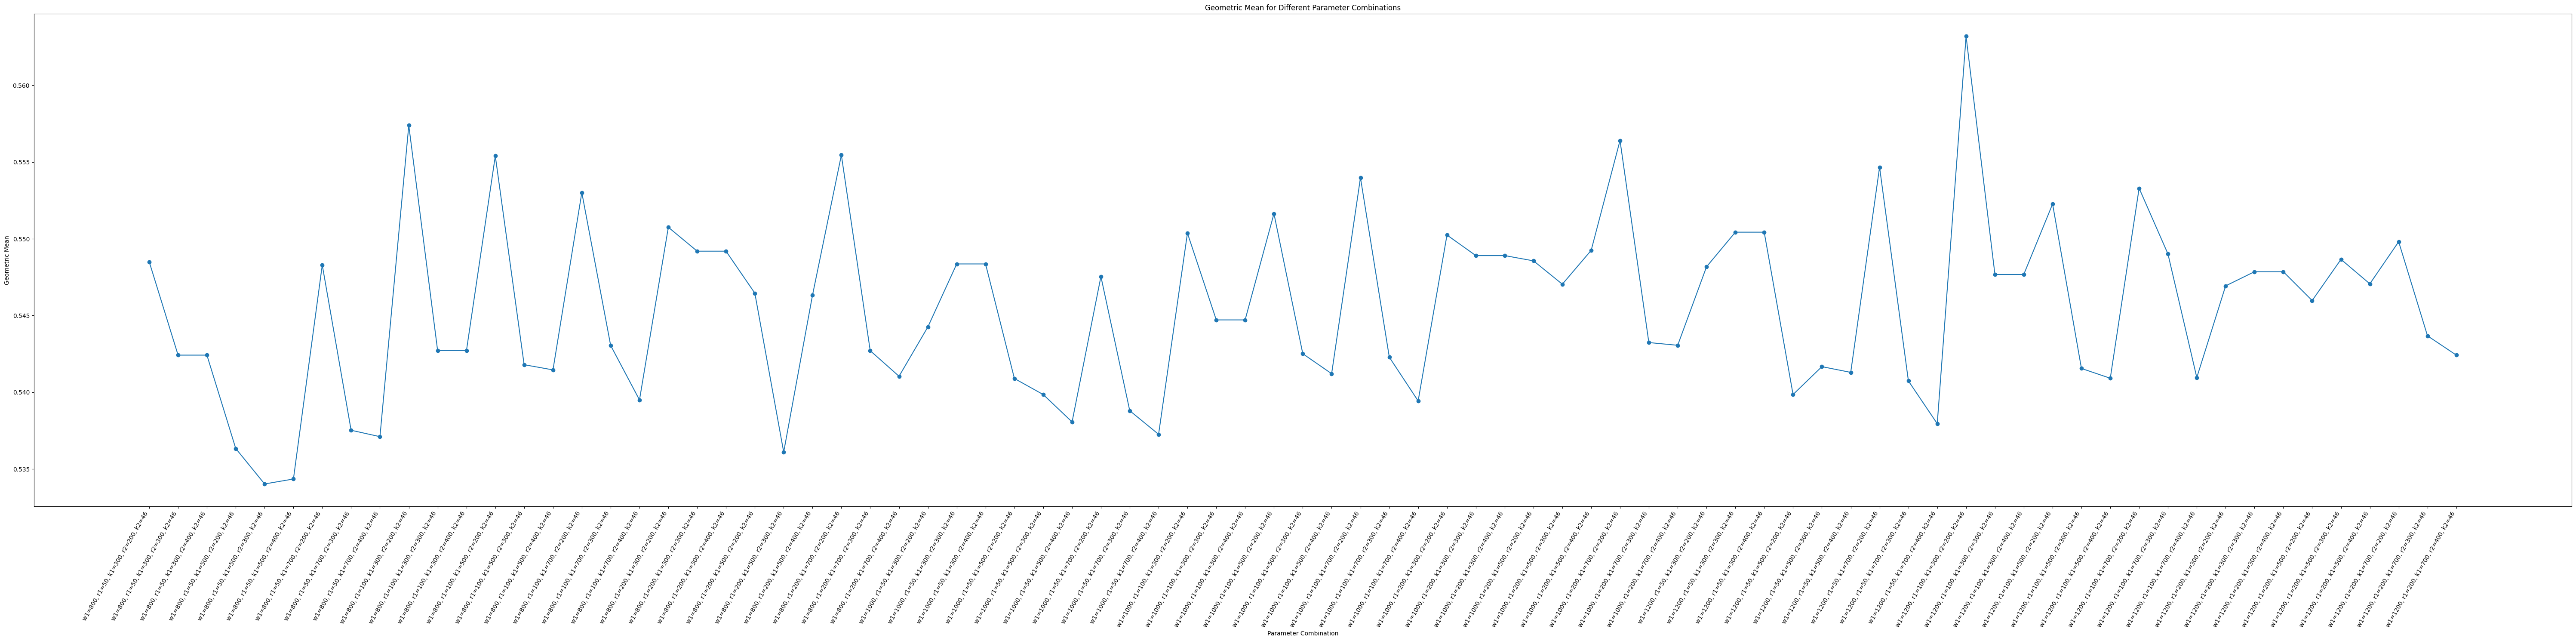

In [30]:
# import matplotlib.pyplot as plt
plt.figure(figsize=(60, 15))
plt.plot(geomean_values, marker='o')
plt.xticks(range(len(geomean_values)), param_labels, rotation=60, ha='right')
plt.xlabel('Parameter Combination')
plt.ylabel('Geometric Mean')
plt.title('Geometric Mean for Different Parameter Combinations')
plt.tight_layout()
plt.show()

## Plotting the geometric mean of the two accuracy metrics > 0.55

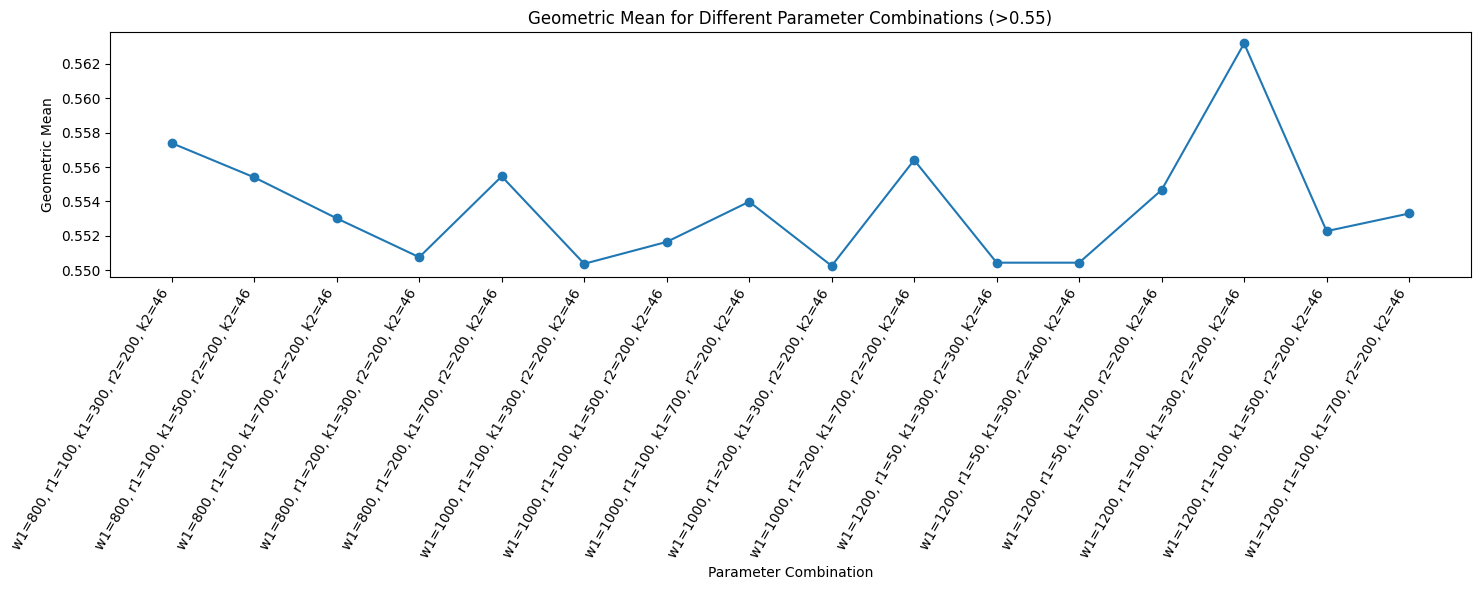

In [33]:
plt.figure(figsize=(15, 6))

filtered_data = [(geomean, label) for geomean, label in zip(geomean_values, param_labels) if geomean > 0.55]
filtered_geomeans, filtered_labels = zip(*filtered_data)

plt.plot(filtered_geomeans, marker='o')
plt.xticks(range(len(filtered_geomeans)), filtered_labels, rotation=60, ha='right')
plt.xlabel('Parameter Combination')
plt.ylabel('Geometric Mean')
plt.title('Geometric Mean for Different Parameter Combinations (>0.55)')
plt.tight_layout()
plt.show()

# Attempt 2


In [ ]:
import nltk
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

# Import SVD2Tagger class
from typing import List, Dict, Tuple

def prepare_treebank_data(tagged_sents: List[List[Tuple[str, str]]]) -> Tuple[np.ndarray, Dict, int]:
    """
    Prepare Penn Treebank data for SVD2Tagger

    Args:
        tagged_sents: List of sentences, where each sentence is a list of (word, tag) tuples

    Returns:
        tokens: numpy array of word IDs
        word_to_id: dictionary mapping words to IDs
        vocab_size: size of vocabulary
    """
    # Build vocabulary
    word_to_id = {}
    words = [word.lower() for sent in tagged_sents for word, _ in sent]

    # Add words to vocabulary with frequency > 1
    word_freq = defaultdict(int)
    for word in words:
        word_freq[word] += 1

    # Create word_to_id mapping
    for word in word_freq:
        if word_freq[word] > 1:  # Only include words that appear more than once
            word_to_id[word] = len(word_to_id)

    # Add <UNK> token
    word_to_id['<UNK>'] = len(word_to_id)

    # Convert words to IDs
    tokens = []
    for sent in tagged_sents:
        for word, _ in sent:
            word = word.lower()
            if word in word_to_id:
                tokens.append(word_to_id[word])
            else:
                tokens.append(word_to_id['<UNK>'])

    return np.array(tokens), word_to_id, len(word_to_id)

def evaluate_clusters(tagger, test_sents, true_tags):
    """
    Evaluate cluster quality against true POS tags
    """
    from sklearn.metrics import v_measure_score, adjusted_rand_score

    # Get cluster assignments for test words
    test_clusters = []
    true_pos_tags = []

    for sent, true_sent in zip(test_sents, true_tags):
        for word, true_tag in zip(sent, true_sent):
            word = word.lower()
            if word in tagger.word_to_id:
                word_id = tagger.word_to_id[word]
                test_clusters.append(tagger.final_clusters[word_id])
                true_pos_tags.append(true_tag)

    # Calculate clustering metrics
    v_measure = v_measure_score(true_pos_tags, test_clusters)
    ari = adjusted_rand_score(true_pos_tags, test_clusters)

    return {
        'v_measure': v_measure,
        'ari': ari
    }

def main():
    # Load Penn Treebank data
    print("Loading Penn Treebank data...")
    corpus = nltk.corpus.treebank.tagged_sents()

    # Split into train and test
    train_size = int(len(corpus) * 0.8)
    train_data = corpus[:train_size]
    test_data = corpus[train_size:]

    # Prepare data
    print("Preparing data...")
    tokens, word_to_id, vocab_size = prepare_treebank_data(train_data)

    # Initialize and train SVD2Tagger
    print("Training SVD2Tagger...")
    tagger = SVD2Tagger(w1=1000, r1=100, k1=500, r2=300, k2=45)
    clusters = tagger.fit(tokens, vocab_size, word_to_id)

    # Save word_to_id mapping in tagger
    tagger.word_to_id = word_to_id
    tagger.id_to_word = {v: k for k, v in word_to_id.items()}

    # Print cluster examples
    print("\nCluster Examples:")
    tagger.get_cluster_examples(tokens, word_to_id)

    # Prepare test data for evaluation
    test_words = [[word.lower() for word, _ in sent] for sent in test_data]
    test_tags = [[tag for _, tag in sent] for sent in test_data]

    # Evaluate clusters
    print("\nEvaluating clusters...")
    metrics = evaluate_clusters(tagger, test_words, test_tags)
    print(f"V-measure score: {metrics['v_measure']:.4f}")
    print(f"Adjusted Rand Index: {metrics['ari']:.4f}")

    # Print some example tags
    print("\nExample Tagging:")
    example_sent = "banana banana banana banana apple.".lower().split()
    word_ids = [word_to_id.get(word, word_to_id['<UNK>']) for word in example_sent]
    clusters = [tagger.final_clusters[wid] for wid in word_ids]

    for word, cluster in zip(example_sent, clusters):
        print(f"{word}: Cluster-{cluster}")

if __name__ == "__main__":
    main()

Loading Penn Treebank data...
Preparing data...
Training SVD2Tagger...
Building initial context matrices...
Performing first SVD transformation...
Performing first clustering...
Building refined context matrices...
Performing second SVD transformation...
Performing final clustering...

Cluster Examples:
Cluster 0: 55, 30, 1.5, 9, 27
Cluster 1: lorillard, york-based, 's, heard, questionable
Cluster 2: board, director, form, deaths, decades
Cluster 3: nov., early, hollingsworth, virtually, money-market
Cluster 4: old, dutch, former, british, kent
Cluster 5: vinken, vitulli, spoon, ross, cray
Cluster 6: once, it, researchers, even, although
Cluster 7: join, make, findings, bring, be
Cluster 8: *-5, like, banned, hopes, attempts
Cluster 9: still, looking, worried, closed, priced
Cluster 10: risk, appears, continues, continue, expects
Cluster 11: reported, stopped, worked, dumped, suspended
Cluster 12: will, is, was, has, were
Cluster 13: *-1, *-2, attention, *-3, *-4
Cluster 14: mr., dr., 

# MISC

## Unique tags

In [ ]:
def find_unique_tags(tagged_sents: List[List[Tuple[str, str]]]) -> int:
    """
    Find the number of unique tags in a tagged corpus.

    Args:
        tagged_sents: List of sentences, where each sentence is a list of (word, tag) tuples

    Returns:
        Number of unique tags
    """
    # Extract all tags from the tagged sentences
    tags = [tag for sent in tagged_sents for _, tag in sent]

    # Use a set to find unique tags
    unique_tags = set(tags)
    print(unique_tags)

    # Return the number of unique tags
    return len(unique_tags)

# Example usage:
corpus = nltk.corpus.treebank.tagged_sents()
unique_tag_count = find_unique_tags(corpus)
print(f"Number of unique tags: {unique_tag_count}")

{'DT', '-RRB-', 'VBZ', 'WP', '$', 'NNP', 'CC', 'NNS', 'VBP', 'RBS', 'CD', 'WP$', 'POS', 'PRP', 'RP', 'SYM', "''", 'RB', 'JJ', 'VB', '``', 'JJS', '-LRB-', 'VBG', 'TO', 'NNPS', '#', 'PDT', 'NN', 'EX', ',', 'WRB', 'VBD', 'WDT', 'LS', '-NONE-', 'UH', 'MD', 'PRP$', ':', '.', 'IN', 'RBR', 'JJR', 'VBN', 'FW'}
Number of unique tags: 46


## SVD2 with proper documentation

In [ ]:
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from collections import defaultdict

class SVD2Tagger:
    def __init__(self, w1=1000, r1=100, k1=500, r2=300, k2=45):
        """
        Initialize SVD2 tagger with parameters.

        Args:
            w1 (int): Number of most frequent words for context. Default is 1000.
            r1 (int): Rank for first SVD. Default is 100.
            k1 (int): Number of clusters for first clustering. Default is 500.
            r2 (int): Rank for second SVD. Default is 300.
            k2 (int): Final number of POS tags. Default is 45.
        """
        self.w1 = w1
        self.r1 = r1
        self.k1 = k1
        self.r2 = r2
        self.k2 = k2

    def build_context_matrices(self, tokens, vocab_size, word_to_id):
        """
        Build left and right context matrices.

        Args:
            tokens (list): List of token IDs.
            vocab_size (int): Size of the vocabulary.
            word_to_id (dict): Mapping of words to their corresponding IDs.

        Returns:
            tuple: Left context matrix (L) and right context matrix (R).
        """
        # Get most frequent word indices
        word_counts = np.bincount(tokens)
        top_words = np.argsort(word_counts)[-self.w1:]

        # Initialize context matrices
        L = np.zeros((vocab_size, self.w1))
        R = np.zeros((vocab_size, self.w1))

        # Fill context matrices
        for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # Right context
            next_word = tokens[i+1]
            if next_word in top_words:
                R[curr_word, np.where(top_words == next_word)[0][0]] += 1

            # Left context
            if i > 0:
                prev_word = tokens[i-1]
                if prev_word in top_words:
                    L[curr_word, np.where(top_words == prev_word)[0][0]] += 1

        return L, R

    def svd_transform(self, matrix, rank):
        """
        Perform reduced rank SVD and return transformed matrix.

        Args:
            matrix (numpy.ndarray): Input matrix.
            rank (int): Desired rank for SVD.

        Returns:
            numpy.ndarray: Transformed matrix after SVD.
        """
        U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
        # Keep only top rank singular values
        S = np.diag(S[:rank])
        U = U[:, :rank]
        return normalize(U @ S)

    def cluster_descriptors(self, descriptors, n_clusters, word_counts):
        """
        Perform weighted k-means clustering.

        Args:
            descriptors (numpy.ndarray): Matrix of word descriptors.
            n_clusters (int): Number of clusters.
            word_counts (numpy.ndarray): Array of word counts.

        Returns:
            numpy.ndarray: Cluster assignments for each word.
        """
        # Initialize centroids with most frequent words
        top_indices = np.argsort(word_counts)[-n_clusters:]
        init_centroids = descriptors[top_indices]

        kmeans = KMeans(n_clusters=n_clusters, init=init_centroids, n_init=1)
        return kmeans.fit_predict(descriptors)

    def fit(self, tokens, vocab_size, word_to_id):
        """
        Perform full SVD2 training process.

        Args:
            tokens (list): List of token IDs.
            vocab_size (int): Size of the vocabulary.
            word_to_id (dict): Mapping of words to their corresponding IDs.

        Returns:
            numpy.ndarray: Final cluster assignments for each word.
        """
        # First pass
        print("Building initial context matrices...")
        L1, R1 = self.build_context_matrices(tokens, vocab_size, word_to_id)

        print("Performing first SVD transformation...")
        L1_transformed = self.svd_transform(L1, self.r1)
        R1_transformed = self.svd_transform(R1, self.r1)

        # Concatenate descriptors
        descriptors1 = np.hstack([L1_transformed, R1_transformed])

        print("Performing first clustering...")
        word_counts = np.bincount(tokens)
        first_clusters = self.cluster_descriptors(descriptors1, self.k1, word_counts)

        # Second pass
        print("Building refined context matrices...")
        L2 = np.zeros((vocab_size, self.k1))
        R2 = np.zeros((vocab_size, self.k1))

        # Fill second pass context matrices using cluster assignments
        for i in range(len(tokens)-1):
            curr_word = tokens[i]
            # Right context
            next_word = tokens[i+1]
            R2[curr_word, first_clusters[next_word]] += 1

            # Left context
            if i > 0:
                prev_word = tokens[i-1]
                L2[curr_word, first_clusters[prev_word]] += 1

        print("Performing second SVD transformation...")
        L2_transformed = self.svd_transform(L2, self.r2)
        R2_transformed = self.svd_transform(R2, self.r2)

        # Final clustering
        print("Performing final clustering...")
        descriptors2 = np.hstack([L2_transformed, R2_transformed])
        self.final_clusters = self.cluster_descriptors(descriptors2, self.k2, word_counts)

        return self.final_clusters

    def get_cluster_examples(self, tokens, word_to_id, n_examples=5):
        """
        Get example words for each cluster.

        Args:
            tokens (list): List of token IDs.
            word_to_id (dict): Mapping of words to their corresponding IDs.
            n_examples (int): Number of example words to retrieve per cluster. Default is 5.
        """
        id_to_word = {v: k for k, v in word_to_id.items()}
        cluster_examples = defaultdict(list)

        for word_id in range(len(self.final_clusters)):
            cluster = self.final_clusters[word_id]
            if word_id in id_to_word:
                word = id_to_word[word_id]
                cluster_examples[cluster].append(word)

        # Print top n examples for each cluster
        for cluster in sorted(cluster_examples.keys()):
            examples = cluster_examples[cluster][:n_examples]
            print(f"Cluster {cluster}: {', '.join(examples)}")

# - The `SVD2Tagger` class docstring describes the purpose of the class and the meaning of each parameter.
# - The `build_context_matrices` method docstring explains the purpose of the method, the input arguments, and the returned context matrices.
# - The `svd_transform` method docstring describes the purpose of the method, the input arguments, and the returned transformed matrix.
# - The `cluster_descriptors` method docstring explains the purpose of the method, the input arguments, and the returned cluster assignments.
# - The `fit` method docstring describes the purpose of the method, the input arguments, and the returned final cluster assignments.
# - The `get_cluster_examples` method docstring explains the purpose of the method and the input arguments.